# <a id='toc1_'></a>[Table of contents](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Table of contents](#toc1_)    
- [Pre-processing and cleaning approved drugs (ChEMBL Web Resource)](#toc2_)    
  - [Importing packages and data](#toc2_1_)    
  - [Pre-process](#toc2_2_)    
    - [Only essential variables](#toc2_2_1_)    
    - [Basic filter (only small molecules and therapeutic drugs)](#toc2_2_2_)    
    - [Separating for manual curation](#toc2_2_3_)    
    - [Calculating Molecular Weight (MW) and use it as filter](#toc2_2_4_)    
    - [Removing the salts, neutralize atoms and keep only the largest fragments](#toc2_2_5_)    
    - [Final tweaking](#toc2_2_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Flow Chart](#toc0_)

![flowchard_pre_cleaning.jpeg](https://raw.githubusercontent.com/arturcgs/masters-project/main/main_project/imgs/flowcharts/pre_cleaning.jpeg?token=GHSAT0AAAAAAB5GINDWRM3G6IZSY7CH5KIWZBDFTHQ)

# <a id='toc2_'></a>[Pre-processing and cleaning approved drugs (ChEMBL Web Resource)](#toc0_)

In this step, we drop some missing and irrelevant stuff and reorder stuff. The objective of this notebook is to do the pre-cleaning and cleaning of the dataset gathered from ChEMBL Web Resource. More info about it below.

The ChEMBL Web Resource, as defined by the authors and mantainers in [GitHub](https://github.com/chembl/chembl_webresource_client): *'The library helps accessing ChEMBL data and cheminformatics tools from Python. You don't need to know how to write SQL. You don't need to know how to interact with REST APIs. You don't need to compile or install any cheminformatics frameworks. Results are cached.'*

## <a id='toc2_1_'></a>[Importing packages and data](#toc0_)

This section is dedicated to **import the packages and libraries** that we're going to use in this notebook, aswell as **the data** retrieved from *ChEMBL Web Resource* (more info above).

In [1]:
import pandas as pd
import re
import session_info

from rdkit import Chem, rdBase
from rdkit.Chem import Draw, Descriptors, PandasTools, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.SaltRemover import SaltRemover, InputFormat
from rdkit.Chem import rdmolops # To clean the structures

from IPython.display import HTML

In [2]:
# defining function that shows the dataframe with images for the molecules
def show_df(df):
    return HTML(df.to_html(notebook=True))

In [3]:
# Importing the dataset:
approved_drugs_df = pd.read_csv('../data/RAW_datasets/RAW_approved_drugs.csv')

## <a id='toc2_2_'></a>[Pre-cleaning process](#toc0_)

### <a id='toc2_2_1_'></a>[Only essential variables](#toc0_)

Taking a peek into the data we can see that there are a lot of variables that we don't need aswell as some rows depicting "NaN". We need to filter the bulk of information then refine it. This is the objective of the pre-process step.
As we can see below, we have 4121 strucutres and 39 variables. Now it is time to clean it!

In [4]:
# List of variables
print(approved_drugs_df.columns, "\n\n",approved_drugs_df.shape )
# Taking a peek into the data
approved_drugs_df.head(5)

Index(['atc_classifications', 'availability_type', 'biotherapeutic',
       'black_box_warning', 'chebi_par_id', 'chirality', 'cross_references',
       'dosed_ingredient', 'first_approval', 'first_in_class', 'helm_notation',
       'indication_class', 'inorganic_flag', 'max_phase', 'molecule_chembl_id',
       'molecule_hierarchy', 'molecule_properties', 'molecule_structures',
       'molecule_synonyms', 'molecule_type', 'natural_product', 'oral',
       'parenteral', 'polymer_flag', 'pref_name', 'prodrug', 'structure_type',
       'therapeutic_flag', 'topical', 'usan_stem', 'usan_stem_definition',
       'usan_substem', 'usan_year', 'withdrawn_flag', 'SMILES'],
      dtype='object') 

 (4194, 35)


,atc_classifications,availability_type,biotherapeutic,black_box_warning,chebi_par_id,chirality,cross_references,dosed_ingredient,first_approval,first_in_class,...,prodrug,structure_type,therapeutic_flag,topical,usan_stem,usan_stem_definition,usan_substem,usan_year,withdrawn_flag,SMILES
0,['V03AN03'],1,NaN,0,30217.0,2,[],True,2015.0,0,...,0,MOL,False,True,-ium,quaternary ammonium derivatives,-ium,NaN,False,[He]
1,['V09GX05'],1,NaN,0,NaN,2,"[{'xref_id': 'ammonia%20n-13', 'xref_name': 'a...",True,2007.0,0,...,0,MOL,False,False,NaN,NaN,NaN,1990.0,False,[13NH3]
2,[],1,NaN,0,16134.0,2,"[{'xref_id': 'ammonia%20n-13', 'xref_name': 'a...",False,2007.0,0,...,0,MOL,False,False,NaN,NaN,NaN,1990.0,False,N
3,[],2,NaN,0,15377.0,2,"[{'xref_id': 'purified%20water', 'xref_name': ...",True,2011.0,0,...,0,MOL,False,True,deu-,deuterated compounds,deu-,1963.0,False,O
4,['V03AN04'],1,NaN,0,17997.0,2,[],True,2015.0,0,...,0,MOL,False,True,NaN,NaN,NaN,NaN,False,N#N


In [5]:
# Verifying the 'not found' SMILES
print("Number of 'not found' SMILES, before filtering: ", approved_drugs_df.query("SMILES == 'not found'").shape[0])

Number of 'not found' SMILES, before filtering:  700


We can filter the information and select only these variables:
* pref_name
* SMILES
* molecule_chembl_id
* first_approval
* molecule_type
* indication_class
* polymer_flag
* withdrawn_flag
* withdrawn_year
* inorganic_flag
* therapeutic_flag
* natural_product
* oral
* parenteral
* topical

In [6]:
approved_drugs_df = approved_drugs_df[[
    'pref_name',
    'SMILES',
    'molecule_chembl_id',
    'first_approval',
    'molecule_type',
    'indication_class',
    'polymer_flag',
    'withdrawn_flag',
    'inorganic_flag',
    'therapeutic_flag',
    'natural_product',
    'oral', 
    'parenteral', 
    'topical',
]].copy()

# Important note: the copy method is used here because one should not work with a slice of the dataframe

### <a id='toc2_2_2_'></a>[Basic filter (only small molecules and therapeutic drugs)](#toc0_)

Next we do the following pre-cleaning steps:
* Filter only the *Small molecules* on the `molecule_type` variable;
* Remove strictly *inorganic* and *polymers*;
* Remove radioactive, gases, diluent, excipients, plutnium, aid, disinfectants, diagnostic, preservative and flavor tagged strucutres;
* Only `therapeutic_flag` == True

In [7]:
# Filtering the structures:
# We want only 'Small molecule', don't want inorganic or polymer stuff
approved_drugs_df = approved_drugs_df.loc[approved_drugs_df['molecule_type'] == 'Small molecule']
approved_drugs_df = approved_drugs_df.loc[approved_drugs_df['inorganic_flag'] == 0]
approved_drugs_df = approved_drugs_df.loc[approved_drugs_df['polymer_flag'] == 0]

# We don't want indication_class containing the word "gases" or "diluent" or "radioactive"
approved_drugs_df = approved_drugs_df[~approved_drugs_df['indication_class'].str.contains("radioactive|gases|diluent|disinfectant|flavor|preservative|diagnostic|excipient|plutonium|aid", flags=re.IGNORECASE, regex=True, na=False)]

# with terapeutic_flag == True
approved_drugs_df = approved_drugs_df[approved_drugs_df['therapeutic_flag'] == True]
approved_drugs_df

,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical
5,NITRIC OXIDE,[N]=O,CHEMBL1200689,1999.0,Small molecule,NaN,0,False,0,True,0,False,False,True
9,HYDROGEN PEROXIDE,OO,CHEMBL71595,2017.0,Small molecule,"Anti-Infective, Topical",0,False,0,True,0,False,False,True
14,NITROUS OXIDE,[N-]=[N+]=O,CHEMBL1234579,NaN,Small molecule,Anesthetic (inhalation),0,False,0,True,0,False,False,False
23,GUANIDINE,N=C(N)N,CHEMBL821,1939.0,Small molecule,NaN,0,False,0,True,0,True,False,False
24,GUANIDINE HYDROCHLORIDE,Cl.N=C(N)N,CHEMBL1200728,1939.0,Small molecule,NaN,0,False,0,True,0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3942,CRYPTENAMINE TANNATES,not found,CHEMBL1201603,1982.0,Small molecule,NaN,0,False,0,True,1,True,False,False
3953,"ESTROGENS, ESTERIFIED",not found,CHEMBL1201468,1977.0,Small molecule,Estrogen,0,False,0,True,1,True,False,False
3958,ALKAVERVIR,not found,CHEMBL1201658,1982.0,Small molecule,NaN,0,False,0,True,1,True,False,False
3970,"ESTROGENS, CONJUGATED SYNTHETIC A",not found,CHEMBL1201466,1999.0,Small molecule,NaN,0,False,0,True,0,True,False,True


On the step above we left only **2952** from the **4194** in the start. We need to save the SMILES and first approval date not found for manual curation and to complete the dataset further on. Also, the index is messed up.

### <a id='toc2_2_4_'></a>[Calculating Molecular Weight (MW) and use it as filter](#toc0_)

Observing the dataset previously we noted that it does not make any sense to keep structures less than 60 Da as it is just water, nitrogen oxide, oxigenated water, etc... 

Before we calculate the molecular weight, we need to generate the `MOL` format of the SMILES as the `RDKit` function only works on this kind of format

In [8]:
# saving molecules with SMILES in the main dataset
main_df = approved_drugs_df[approved_drugs_df.SMILES != "not found"].copy()

# saving molecules with SMILES not found in the manula curatin dataset
manual_curation_smiles_year_df = approved_drugs_df[approved_drugs_df.SMILES == "not found"].copy()

print(f"Main dataset size: {main_df.shape[0]}\nManual curation dataset size: {manual_curation_smiles_year_df.shape[0]}")

Main dataset size: 2903
Manual curation dataset size: 49


RDKit WARNING: [10:57:25] WARNING: not removing hydrogen atom without neighbors
[10:57:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:57:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:57:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:57:25] WARNING: not removing hydrogen atom without neighbors
[10:57:25] WARNING: not removing hydrogen atom without neighbors
[10:57:25] WARNING: not removing hydrogen atom without neighbors
[10:57:25] WARNING: not removing hydrogen atom without neighbors


,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,ROMol
5,NITRIC OXIDE,[N]=O,CHEMBL1200689,1999.0,Small molecule,NaN,0,False,0,True,0,False,False,True,
9,HYDROGEN PEROXIDE,OO,CHEMBL71595,2017.0,Small molecule,"Anti-Infective, Topical",0,False,0,True,0,False,False,True,
14,NITROUS OXIDE,[N-]=[N+]=O,CHEMBL1234579,NaN,Small molecule,Anesthetic (inhalation),0,False,0,True,0,False,False,False,
23,GUANIDINE,N=C(N)N,CHEMBL821,1939.0,Small molecule,NaN,0,False,0,True,0,True,False,False,
24,GUANIDINE HYDROCHLORIDE,Cl.N=C(N)N,CHEMBL1200728,1939.0,Small molecule,NaN,0,False,0,True,0,True,False,False,

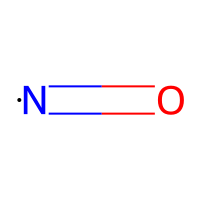
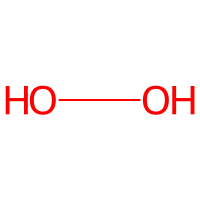
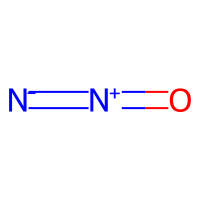
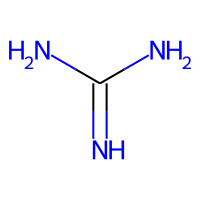
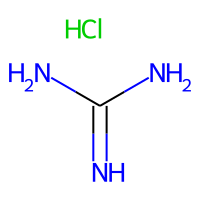

In [9]:
# Creating a ROMol column from SMILES format
PandasTools.AddMoleculeColumnToFrame(main_df, smilesCol='SMILES')

# Checking to see if it worked properly
show_df(main_df.head(5))

Dataset size after filtering with MW: 2897


,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,ROMol,mw
6,ACETOHYDROXAMIC ACID,CC(=O)NO,CHEMBL734,1983.0,Small molecule,Enzyme Inhibitor (urease),0,False,0,True,0,True,False,False,,75.032028
7,HYDROXYUREA,NC(=O)NO,CHEMBL467,1967.0,Small molecule,Antineoplastic,0,False,0,True,0,True,False,False,,76.027277
8,CYSTEAMINE,NCCS,CHEMBL602,1994.0,Small molecule,Anti-Urolithic (cystine calculi),0,False,0,True,0,True,False,True,,77.029920
9,DIMETHYL SULFOXIDE,C[S+](C)[O-],CHEMBL504,1978.0,Small molecule,Anti-Inflammatory (topical),0,False,0,True,0,False,True,False,,78.013936
10,FOMEPIZOLE,Cc1cn[nH]c1,CHEMBL1308,1997.0,Small molecule,Antidote (alcohol dehydrogenase inhibitor),0,False,0,True,0,False,True,False,,82.053098
11,PIPERAZINE,C1CNCCN1,CHEMBL1412,NaN,Small molecule,Anthelmintic,0,True,0,True,0,False,False,False,,86.084398

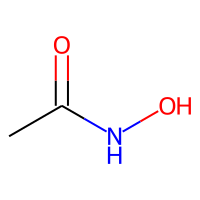
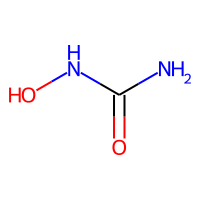
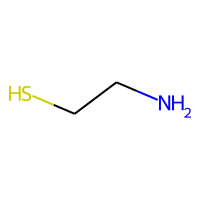
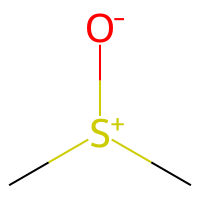
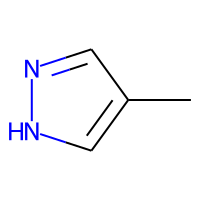
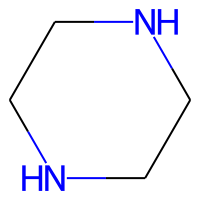

In [10]:
# Calculating the Molecular Weight and sorting by it
main_df['mw'] = main_df['ROMol'].apply(Descriptors.ExactMolWt)

main_df = main_df.sort_values(by="mw").reset_index(drop=True)

# Dropping molecules lower than 75 Da
main_df = main_df.query('mw >= 75').copy()

print(f"Dataset size after filtering with MW: {main_df.shape[0]}")
show_df(main_df.head(6))

### <a id='toc2_2_3_'></a>[Separating molecules without Year of Approval](#toc0_)

In [11]:
# adding molecules without the Year of Approval to the manual curation dataset
manual_curation_smiles_year_df = pd.concat([manual_curation_smiles_year_df, main_df[main_df['first_approval'].isna()]])

# dropping these molecules from tha main dataset
main_df = main_df[~main_df['first_approval'].isna()]

print(f"Main dataset size: {main_df.shape[0]}\nManual curation dataset size: {manual_curation_smiles_year_df.shape[0]}")

Main dataset size: 2406
Manual curation dataset size: 540


In [12]:
# dropping ROMOL collumn
manual_curation_smiles_year_df = manual_curation_smiles_year_df.drop(axis=1, labels="ROMol")

# saving dataset
manual_curation_smiles_year_df.to_csv("../data/pre_manual_curation/manual_curation_smiles_year.csv", index=False)

### <a id='toc2_2_5_'></a>[Removing Salts](#toc0_)

Removing Salts is a crucial step to calculate the molecule's properties. To do this, usually the fragments from the mol file are separates, and only the largest one is kept. However, doing this in this dataset, we noticed that it doesn't work for some molecules. Because of this, we are going for a more manual strategy.

First, we select all molecules that have fragments. With these, we counted the words in each molecule. The most commom words are mostly salt names. With the most commom salt names, we dropped all the salts that are very small (such as hydrocloride, sodium, calcium, etc). Now, the molecules that are left will be manually curated. To help in this curation, we performed the "keep the largest fragment" strategy. With this, we can analyse the dataset, in another notebook, and look at all molecules. The ones that were selected correctly are kept, and the ones that weren't will have the salt removed manually.


There are 877 molecules with fragments in the dataset


,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,ROMol,mw
15,GUANIDINE HYDROCHLORIDE,Cl.N=C(N)N,CHEMBL1200728,1939.0,Small molecule,NaN,0,False,0,True,0,True,False,False,,95.025025
19,AMMONIUM LACTATE,CC(O)C(=O)O.N,CHEMBL1200747,1985.0,Small molecule,Antipruritic (topical),0,False,0,True,0,False,False,True,,107.058243
24,CYSTEAMINE HYDROCHLORIDE,Cl.NCCS,CHEMBL1256137,2012.0,Small molecule,Anti-Urolithic (cystine calculi),0,False,0,True,0,False,False,True,,113.006598
34,SODIUM OXYBATE,O=C([O-])CCCO.[Na+],CHEMBL1200682,2002.0,Small molecule,"Anesthesia, Adjunct To",0,False,0,True,0,True,False,False,,126.029288
76,BETAZOLE HYDROCHLORIDE,Cl.NCCc1cc[nH]n1,CHEMBL1200949,1982.0,Small molecule,NaN,0,False,0,True,0,False,True,False,,147.056325
79,SEVELAMER,C=CCN.ClCC1CO1,CHEMBL1201798,2007.0,Small molecule,NaN,0,False,0,True,0,True,False,False,,149.060742
103,ALLOPURINOL SODIUM,O=c1[n-]cnc2[nH]ncc12.[Na+],CHEMBL1200477,1996.0,Small molecule,NaN,0,False,0,True,0,False,True,False,,158.020455
104,SODIUM PHENYLACETATE,O=C([O-])Cc1ccccc1.[Na+],CHEMBL1200358,1987.0,Small molecule,Antihyperammonemic,0,False,0,True,0,True,True,False,,158.034374
119,MESNA,O=S(=O)([O-])CCS.[Na+],CHEMBL975,1988.0,Small molecule,Detoxifying Agent,0,False,0,True,0,True,True,False,,163.957780
122,METFORMIN HYDROCHLORIDE,CN(C)C(=N)NC(=N)N.Cl,CHEMBL1703,1995.0,Small molecule,Antidiabetic,0,False,0,True,0,True,False,False,,165.078123

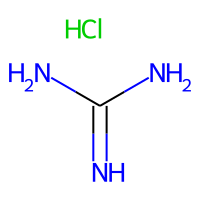
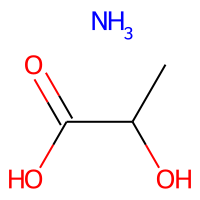
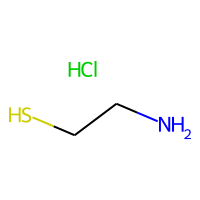
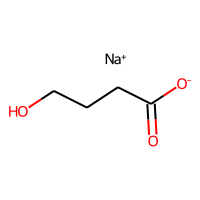
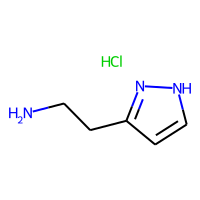
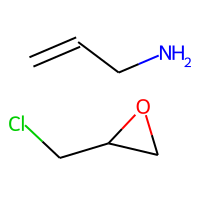
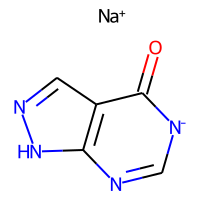
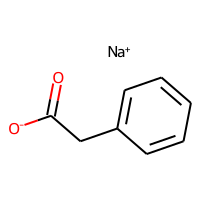
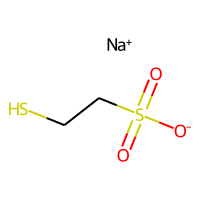
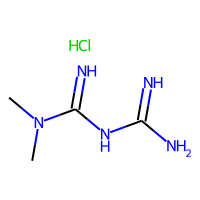

In [13]:
# selecting only the molecules with fragments
# to do this, we filtered for the SMILES that contain "."

fragments_df = main_df[main_df["SMILES"].str.contains(".", regex=False)]
print(f"There are {fragments_df.shape[0]} molecules with fragments in the dataset")
show_df(fragments_df.head(10))

In [14]:
def count_words(name):
    '''
    This function counts the number of each word in the pref_name collumn
    and saves it to the global variable word_cound
    '''
    global word_count

    name_words = name.split()

    for n in name_words:
        word_count[n] = word_count.get(n, 0) + 1
    
    return name_words

def show_word_count():
    '''
    This function sorts the rod_count global variable,
    prints and returns it
    '''
    word_count_sorted = sorted(word_count, key=word_count.get, reverse=True)

    for word in word_count_sorted:
        print(f"{word}: {word_count[word]}")
    
    return word_count_sorted

Here we will analyse the number of times each words appears in the pref_name collumn. With this, we will be able to find which salts are the most commom.

In [15]:
word_count = {}
fragments_df.pref_name.apply(count_words)

15            [GUANIDINE, HYDROCHLORIDE]
19                   [AMMONIUM, LACTATE]
24           [CYSTEAMINE, HYDROCHLORIDE]
34                     [SODIUM, OXYBATE]
76             [BETAZOLE, HYDROCHLORIDE]
                      ...               
2898         [TELAVANCIN, HYDROCHLORIDE]
2899                          [ERGOLOID]
2900               [ERGOLOID, MESYLATES]
2901         [OMEGA-3-CARBOXYLIC, ACIDS]
2902    [CEFIDEROCOL, SULFATE, TOSYLATE]
Name: pref_name, Length: 877, dtype: object

In [16]:
word_count_sorted = show_word_count()

HYDROCHLORIDE: 308
SODIUM: 109
SULFATE: 45
MESYLATE: 31
MALEATE: 29
PHOSPHATE: 21
BROMIDE: 20
CITRATE: 19
TARTRATE: 18
FUMARATE: 17
CHLORIDE: 15
SUCCINATE: 15
DISODIUM: 14
CALCIUM: 14
POTASSIUM: 11
TOSYLATE: 11
ACETATE: 10
HYDROBROMIDE: 10
LACTATE: 8
BITARTRATE: 7
TROMETHAMINE: 7
DIHYDROCHLORIDE: 7
BESYLATE: 6
NITRATE: 6
PENICILLIN: 5
G: 4
MALATE: 4
PAMOATE: 4
ERYTHROMYCIN: 4
AMPHETAMINE: 3
PROCAINE: 3
DEXTROAMPHETAMINE: 3
DICLOFENAC: 3
METHYLSULFATE: 3
ESOMEPRAZOLE: 3
EDETATE: 3
IODIDE: 3
BENZOATE: 3
GLUCONATE: 3
PITAVASTATIN: 3
DOXYCYCLINE: 3
AMLODIPINE: 3
METOPROLOL: 3
MAGNESIUM: 3
CYSTEAMINE: 2
SEVELAMER: 2
AMINOSALICYLATE: 2
PSEUDOEPHEDRINE: 2
EPHEDRINE: 2
PHENYLEPHRINE: 2
LITHIUM: 2
ISOPROTERENOL: 2
THEOPHYLLINE: 2
GLYCINATE: 2
IBUPROFEN: 2
TRANYLCYPROMINE: 2
BUPROPION: 2
ISOETHARINE: 2
LEVALBUTEROL: 2
ADIPATE: 2
DIPHENHYDRAMINE: 2
TRIPELENNAMINE: 2
ORPHENADRINE: 2
VENLAFAXINE: 2
ZINC: 2
IMIPRAMINE: 2
PENTAZOCINE: 2
TRIMETHOPRIM: 2
WARFARIN: 2
MELPHALAN: 2
MYCOPHENOLATE: 2
FINGOL

Here, we can filter the dataset, removing the molecules with small salts. We have selected these salts for removal:
* HYDROCHLORIDE
* SODIUM
* BROMIDE
* CHLORIDE
* CALCIUM
* DISODIUM
* POTASSIUM
* HYDROBROMIDE
* DIHYDROCHLORIDE
* IODIDE
* ZINC
* MAGNESIUM

In [17]:
fragments_manual_curation_df = fragments_df[
    ~fragments_df['pref_name'].
    str.
    contains(
        "HYDROCHLORIDE|SODIUM|BROMIDE|CHLORIDE|CALCIUM|DISODIUM|POTASSIUM|HYDROBROMIDE|DIHYDROCHLORIDE|IODIDE|ZINC|MAGNESIUM", 
        flags=re.IGNORECASE, 
        regex=True, 
        na=False)
]

print(f"The fragments dataset, for manual curation, contains {fragments_manual_curation_df.shape[0]} molecules")

The fragments dataset, for manual curation, contains 359 molecules


Now, we will apply the "keep the largest fragment" algorithm. With this, it will be easier to manually spot when it fails to select the correct fragment.

In [18]:
def keep_largest_fragment(mol):
    frags = rdmolops.GetMolFrags(mol, asMols=True)
    largest_mol = max(frags, key=lambda x: x.GetNumAtoms())
    return largest_mol

In [19]:
# Keep largest fragment
fragments_manual_curation_df["largest_fragment"] = fragments_manual_curation_df.ROMol.apply(keep_largest_fragment)

/tmp/ipykernel_914631/2159149900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fragments_manual_curation_df["largest_fragment"] = fragments_manual_curation_df.ROMol.apply(keep_largest_fragment)


,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,ROMol,mw,largest_fragment
19,AMMONIUM LACTATE,CC(O)C(=O)O.N,CHEMBL1200747,1985.0,Small molecule,Antipruritic (topical),0,False,0,True,0,False,False,True,,107.058243,
79,SEVELAMER,C=CCN.ClCC1CO1,CHEMBL1201798,2007.0,Small molecule,NaN,0,False,0,True,0,True,False,False,,149.060742,
119,MESNA,O=S(=O)([O-])CCS.[Na+],CHEMBL975,1988.0,Small molecule,Detoxifying Agent,0,False,0,True,0,True,True,False,,163.957780,
137,MERCAPTOPURINE,O.S=c1[nH]cnc2nc[nH]c12,CHEMBL1200751,1953.0,Small molecule,Antineoplastic,0,False,0,True,0,True,False,False,,170.026232,
171,CARBACHOL,C[N+](C)(C)CCOC(N)=O.[Cl-],CHEMBL14,1972.0,Small molecule,Cholinergic (ophthalmic),0,False,0,True,0,False,True,False,,182.082205,
251,ALUMINUM ACETATE,CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].[Al+3],CHEMBL1201015,1976.0,Small molecule,Astringent,0,False,0,True,0,False,False,True,,204.021452,

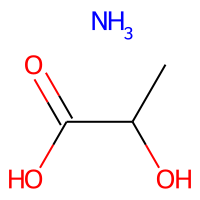
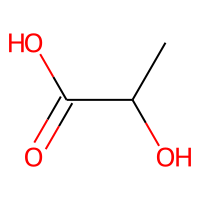
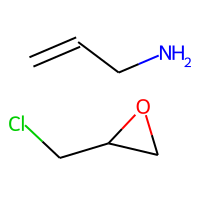
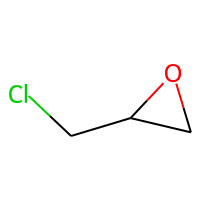
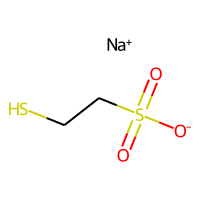
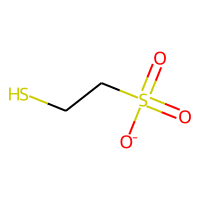
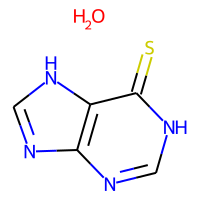
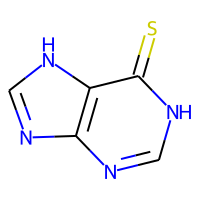
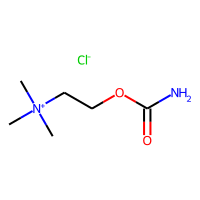
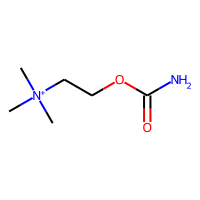
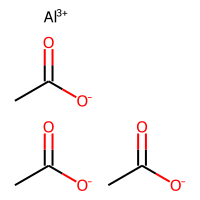
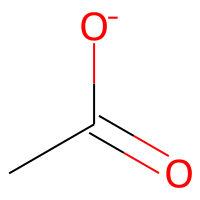

In [20]:
show_df(fragments_manual_curation_df.head(6))

In [21]:
# dropping ROMol collumn
fragments_manual_curation_df = fragments_manual_curation_df.drop(axis=1, labels=["ROMol", "largest_fragment"])

fragments_manual_curation_df.to_csv("../data/pre_manual_curation/manual_curation_fragments.csv", index=False)

In [22]:
# dropping the structures that are going to be manually curated from tha main_df

main_df = main_df.drop(axis=1, index=fragments_manual_curation_df.index).reset_index(drop=True)

print(f"Size of the main dataset: {main_df.shape[0]}")

Size of the main dataset: 2047


### <a id='toc2_2_6_'></a>[Final tweakind (adjusting year format and saving)](#toc0_)

Now we can do some tweaking into our dataframe:
* **Rounding** the number of approval date (just for aesthetic)
* Ordering by MW and drop duplicates SMILES, keeping only the first (usually the base)
* Reseting the index

Size of the main dataset: 2047

Index(['pref_name', 'SMILES', 'molecule_chembl_id', 'first_approval',
       'molecule_type', 'indication_class', 'polymer_flag', 'withdrawn_flag',
       'inorganic_flag', 'therapeutic_flag', 'natural_product', 'oral',
       'parenteral', 'topical', 'ROMol', 'mw'],
      dtype='object')


,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,natural_product,oral,parenteral,topical,ROMol,mw
0,ACETOHYDROXAMIC ACID,CC(=O)NO,CHEMBL734,1983,Small molecule,Enzyme Inhibitor (urease),0,False,0,True,0,True,False,False,,75.032028
1,HYDROXYUREA,NC(=O)NO,CHEMBL467,1967,Small molecule,Antineoplastic,0,False,0,True,0,True,False,False,,76.027277
2,CYSTEAMINE,NCCS,CHEMBL602,1994,Small molecule,Anti-Urolithic (cystine calculi),0,False,0,True,0,True,False,True,,77.029920
3,DIMETHYL SULFOXIDE,C[S+](C)[O-],CHEMBL504,1978,Small molecule,Anti-Inflammatory (topical),0,False,0,True,0,False,True,False,,78.013936
4,FOMEPIZOLE,Cc1cn[nH]c1,CHEMBL1308,1997,Small molecule,Antidote (alcohol dehydrogenase inhibitor),0,False,0,True,0,False,True,False,,82.053098
5,LACTIC ACID,CC(O)C(=O)O,CHEMBL1200559,2006,Small molecule,NaN,0,False,0,True,0,False,True,False,,90.031694

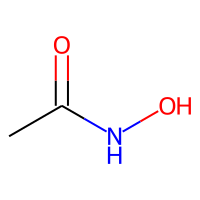
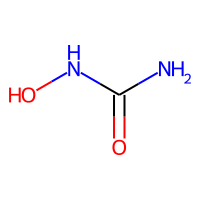
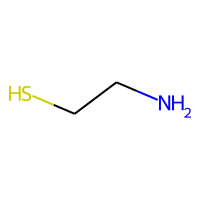
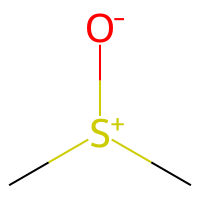
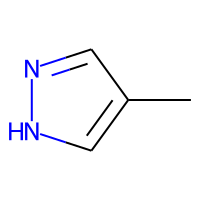
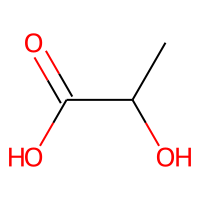

In [23]:
# Changing the year to datetime (int)
main_df['first_approval'] = main_df['first_approval'].astype(int)

print(f"Size of the main dataset: {main_df.shape[0]}\n")
print(main_df.columns)
show_df(main_df.head(6))

In [24]:
# dropping ROMol collumns
main_df = main_df.drop(axis=1, labels="ROMol")

# saving dataset
main_df.to_csv("../data/pre_manual_curation/main_df.csv", index=False)

In [25]:
session_info.show()